# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

# Load the Boston Housing dataset

In [2]:
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame
print(df.head())

# Basic summary
print(df.info())
print(df.describe())

      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    

# Correlation matrix

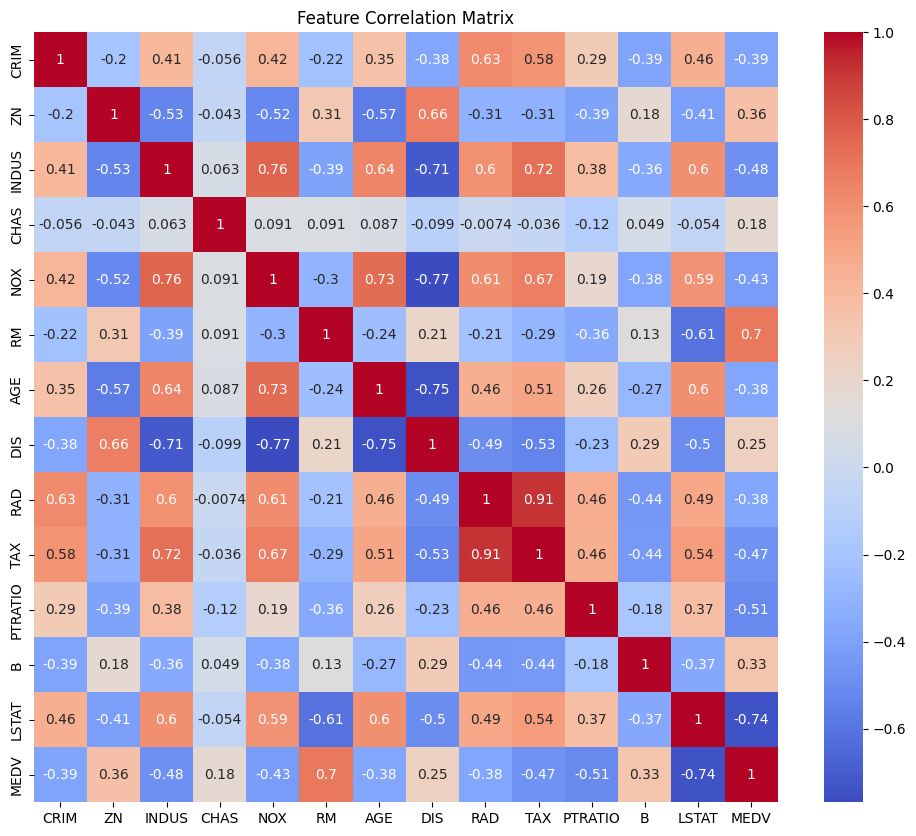

In [3]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Split features and target

In [4]:
X = df.drop(columns=['MEDV', 'NOX', 'TAX'])
y = df['MEDV']

# Scale numeric features

In [8]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Add intercept term

In [ ]:
X_train_sm = sm.add_constant(X_train)

# Fit OLS model

In [11]:
model = sm.OLS(y_train, X_train_sm).fit()

# Summary

In [12]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     98.79
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          1.03e-105
Time:                        17:15:23   Log-Likelihood:                -1206.9
No. Observations:                 404   AIC:                             2438.
Df Residuals:                     392   BIC:                             2486.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4442      0.243     92.337      0.0

# VIF dataframe

In [16]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data.sort_values(by='VIF', ascending=False))


    Feature       VIF
6       DIS  3.846914
2     INDUS  2.910067
5       AGE  2.818093
10    LSTAT  2.779470
7       RAD  2.572043
1        ZN  2.267146
4        RM  1.923274
0      CRIM  1.704735
8   PTRATIO  1.628692
9         B  1.318606
3      CHAS  1.079291


# Add constant

In [17]:
X_train_sm = sm.add_constant(X_train)

# Refit model

In [18]:
model_reduced = sm.OLS(y_train, X_train_sm).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     98.79
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          1.03e-105
Time:                        18:03:27   Log-Likelihood:                -1206.9
No. Observations:                 404   AIC:                             2438.
Df Residuals:                     392   BIC:                             2486.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4442      0.243     92.337      0.0

# Predict on test set

In [19]:
X_test_sm = sm.add_constant(X_test)
y_pred = model_reduced.predict(X_test_sm)


# Metrics

In [20]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n, k = X_test.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Adjusted R²: {adj_r2:.2f}")

RMSE: 5.15
R²: 0.64
Adjusted R²: 0.59


# Building a Predictive System

In [21]:
def predict_new_house_price(input_dict, scaler, model, dropped_features):
    """
    Predict house price from user input.
    input_dict: dictionary of feature_name: value
    scaler: fitted StandardScaler
    model: trained statsmodels model
    dropped_features: list of dropped features (e.g., ['NOX', 'TAX'])
    """
   # Step 1: Convert user input to DataFrame
    user_df = pd.DataFrame([input_dict])

    # Step 2: Drop any features that were dropped during training
    user_df = user_df.drop(columns=dropped_features)

    # Step 3: Reorder columns to match training data
    expected_features = model.model.exog_names.copy()
    if 'const' in expected_features:
        expected_features.remove('const')

    user_df = user_df[expected_features]  # Force correct order

    # Step 4: Scale
    user_scaled = pd.DataFrame(scaler.transform(user_df), columns=expected_features)

    # Step 5: Add constant
    user_scaled_const = user_scaled.copy()
    user_scaled_const.insert(0, 'const', 1.0)

    # Step 6: Check shapes
    print("Model expects:", model.model.exog_names)
    print("You are passing:", user_scaled_const.columns.tolist())
    print("user_scaled_const shape:", user_scaled_const.shape)
    print("params shape:", model.params.shape)

    # Step 7: Predict
    return model.predict(user_scaled_const)[0]

# Predicting new house price 

In [22]:
# Sample input (you can change values as needed)
user_input = {
    'CRIM': 0.05,
    'ZN': 25.0,
    'INDUS': 5.0,
    'CHAS': 0,
    'RM': 6.5,
    'AGE': 45.0,
    'DIS': 4.5,
    'RAD': 4.0,
    'PTRATIO': 15.0,
    'B': 390.0,
    'LSTAT': 8.0
}


# Predict
predicted_price = predict_new_house_price(
    input_dict=user_input,
    scaler=scaler,
    model=model_reduced,
    dropped_features=[]
)

print(f"Predicted Housing Price: ${predicted_price:.2f} (in $1000s)")


Model expects: ['const', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']
You are passing: ['const', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']
user_scaled_const shape: (1, 12)
params shape: (12,)
Predicted Housing Price: $29.52 (in $1000s)
